# 0. Imports & inputs & introductions

This files is written to compare the data sent from James Sturch to compare the mismatch results using Solar Edge system. The email was sent by Jame Sturch and the date was 20/11/2024.

In [1]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime
from datetime import timedelta
import scipy.constants as const
import matplotlib.dates as mdates


# data folder direcotry
data_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\old_data"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results"
# directory for the results folder to investigate for session 6
results_dir = r'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# Define the site to read
# site_id = '1398284'  # Site identifier
# site_id = '347166'
# site_id = '4129142'
# site_id = '3499407'
# site_id = '378878'
# site_id = '3794347'
# site_id = '3996237'
# site_id = '3455043'
site_id = '3499407'


# define the season
# season = 'summer'
season = 'spring'
# season = 'winter'
# season = 'autumn'

# define the module parameter
# ideality_factor = 0.954526056
# num_cells_series = 120
# thermal_voltage_25C = 0.0258
# series_resistance = 0.229
# shunt_resistance = 300

if site_id == '347166':
    ideality_factor = 1.0081
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.302
    shunt_resistance = 400
elif site_id == '1398284':
    ideality_factor = 0.954526056
    num_cells_series = 120
    thermal_voltage_25C = 0.0258
    series_resistance = 0.229
    shunt_resistance = 300
elif site_id == '4129142':
    ideality_factor = 1.029
    num_cells_series = 72
    thermal_voltage_25C = 0.0258
    series_resistance = 0.269
    shunt_resistance = 600
elif site_id == '3499407':
    ideality_factor = 1.03
    num_cells_series = 72
    thermal_voltage_25C = 0.0258
    series_resistance = 0.29
    shunt_resistance = 350
elif site_id == '378878':
    ideality_factor = 0.994
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.176
    shunt_resistance = 1000
elif site_id == '3794347':
    ideality_factor = 1.039
    num_cells_series = 54*2
    thermal_voltage_25C = 0.0258
    series_resistance = 0.133
    shunt_resistance = 1200
elif site_id == '3996237':
    ideality_factor = 1.025
    num_cells_series = 54*2
    thermal_voltage_25C = 0.0258
    series_resistance = 0.161
    shunt_resistance = 260

# Determine fixed x and y axis limits for all plots that plot for each module
y_limit_module = (0, 15)
x_limit_module = (0, 60)  # Assuming a reasonable range for combined voltages

# Determine fixed x and y axis limits for all plots that plot for the combined inverter
y_limit_inverter = (0, 15)
x_limit_inverter = (0, 1000)  # Adjust for combined voltages

# Option to dynamically calculate vth based on panel temperature
use_dynamic_vth = False  # Set to True to enable dynamic calculation, False to use thermal_voltage_25C


In [2]:
# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL


# 1. Read & visualise

## 1.1. Find the site

In [3]:
# Find the directory containing the site_id
site_dir = [d for d in os.listdir(data_dir) if site_id in d][0]

# Full path to the site directory
site_dir = os.path.join(data_dir, site_dir)

print(f"Reading data from {site_dir}")

Reading data from C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\old_data\QLD_3499407


## 1.2. Season data extraction

### 1.2.1. Data extraction

In [4]:
# Define a mapping from season to a list of month names (all in lowercase)
season_months = {
    'summer': ['december', 'january', 'february'],
    'autumn': ['march', 'april', 'may'],
    'winter': ['june', 'july', 'august'],
    'spring': ['september', 'october', 'november']
}

# Ensure the season is in lowercase for matching
season_lower = season.lower()

# Find the folder that contains the season word or any month name corresponding month to that season
season_dir_candidates = [
    d for d in os.listdir(site_dir)
    if (season_lower in d.lower() or any(month in d.lower() for month in season_months.get(season_lower, [])))
]

if not season_dir_candidates:
    raise ValueError("No folder found that contains the specified season or its corresponding months.")

# Choose the first matching folder (or adjust the selection logic as needed)
season_dir = season_dir_candidates[0]

# Full path to the season directory
season_dir = os.path.join(site_dir, season_dir)
print("Season directory found:", season_dir)


# Initialize an empty list to store the DataFrames and a list for reporter IDs
dataframes = []
reporter_ids = []

# Define a list of potential timestamp formats
timestamp_formats = [
    "%Y-%m-%d %H:%M:%S",
    "%d/%m/%Y %H:%M",
    "%m/%d/%Y %H:%M",
    "%Y-%d-%m %H:%M:%S",
    None  # Let pandas infer formats
]

# Loop through the files in the season directory
for file in os.listdir(season_dir):
    if 'optimizer_data' in file and file.endswith('.csv'):
        # Read the CSV file
        optimizer_data = pd.read_csv(os.path.join(season_dir, file))

        # Extract the reporter_id from the file name
        reporter_id = file.split('_')[-1].split('.')[0]
        reporter_ids.append(reporter_id)

        # Rename the columns, including "power"
        optimizer_data.rename(columns={
            'panel_current': f'panel_current_{reporter_id}',
            'panel_voltage': f'panel_voltage_{reporter_id}',
            'temperature': f'temperature_{reporter_id}',
            'panel_temperature': f'panel_temperature_{reporter_id}',
            'power': f'power_{reporter_id}'
        }, inplace=True)

        # Rename the first column to "Timestamp"
        optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)

        # Convert the "Timestamp" column to a datetime
        for fmt in timestamp_formats:
            try:
                optimizer_data['Timestamp'] = pd.to_datetime(optimizer_data['Timestamp'], format=fmt)
                break
            except (ValueError, TypeError):
                pass

        # Set the index to the Timestamp
        optimizer_data.set_index('Timestamp', inplace=True)

        # Keep only the renamed columns
        optimizer_data = optimizer_data[[f'panel_current_{reporter_id}',
                                         f'panel_voltage_{reporter_id}',
                                         f'temperature_{reporter_id}',
                                         f'panel_temperature_{reporter_id}',
                                         f'power_{reporter_id}']]

        # Append the DataFrame to the list
        dataframes.append(optimizer_data)

# Make sure all files have the same Timestamps:
# Find the earliest and latest timestamps across all DataFrames
earliest_timestamp = max([df.index[0] for df in dataframes])
latest_timestamp = min([df.index[-1] for df in dataframes])
# Create a new index from the earliest to the latest timestamp with a 5-minute frequency
new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')

# Reindex the DataFrames, filling missing timestamps with NaN
for i in range(len(dataframes)):
    for index in new_index:
        if index not in dataframes[i].index:
            dataframes[i].loc[index] = np.nan

# Merge all DataFrames on the Timestamp index
if dataframes:
    merged_data = pd.concat(dataframes, axis=1)

# Reset the index for a clean DataFrame
merged_data.reset_index(inplace=True)

print(merged_data)


Season directory found: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\old_data\QLD_3499407\september_2024-09-20_2024-09-30


C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\3866276976.py:90: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')


               Timestamp  panel_current_229481160  panel_voltage_229481160  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.151317                30.793239   
3    2024-09-20 06:00:00                 0.192742                30.953401   
4    2024-09-20 06:05:00                 0.235249                30.575567   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.121147                29.102454   
2734 2024-09-29 17:35:00                 0.100000                28.750000   
2735 2024-09-29 17:40:00                      NaN                      NaN   
2736 2024-09-29 17:45:00                      NaN                      NaN   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_229481160  panel_temperature_229481160  power

### 1.2.2. Visualisation

#### 1.2.2.1. Include temperature

               Timestamp  panel_current_229481160  panel_voltage_229481160  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.151317                30.793239   
3    2024-09-20 06:00:00                 0.192742                30.953401   
4    2024-09-20 06:05:00                 0.235249                30.575567   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.121147                29.102454   
2734 2024-09-29 17:35:00                 0.100000                28.750000   
2735 2024-09-29 17:40:00                      NaN                      NaN   
2736 2024-09-29 17:45:00                      NaN                      NaN   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_229481160  panel_temperature_229481160  power

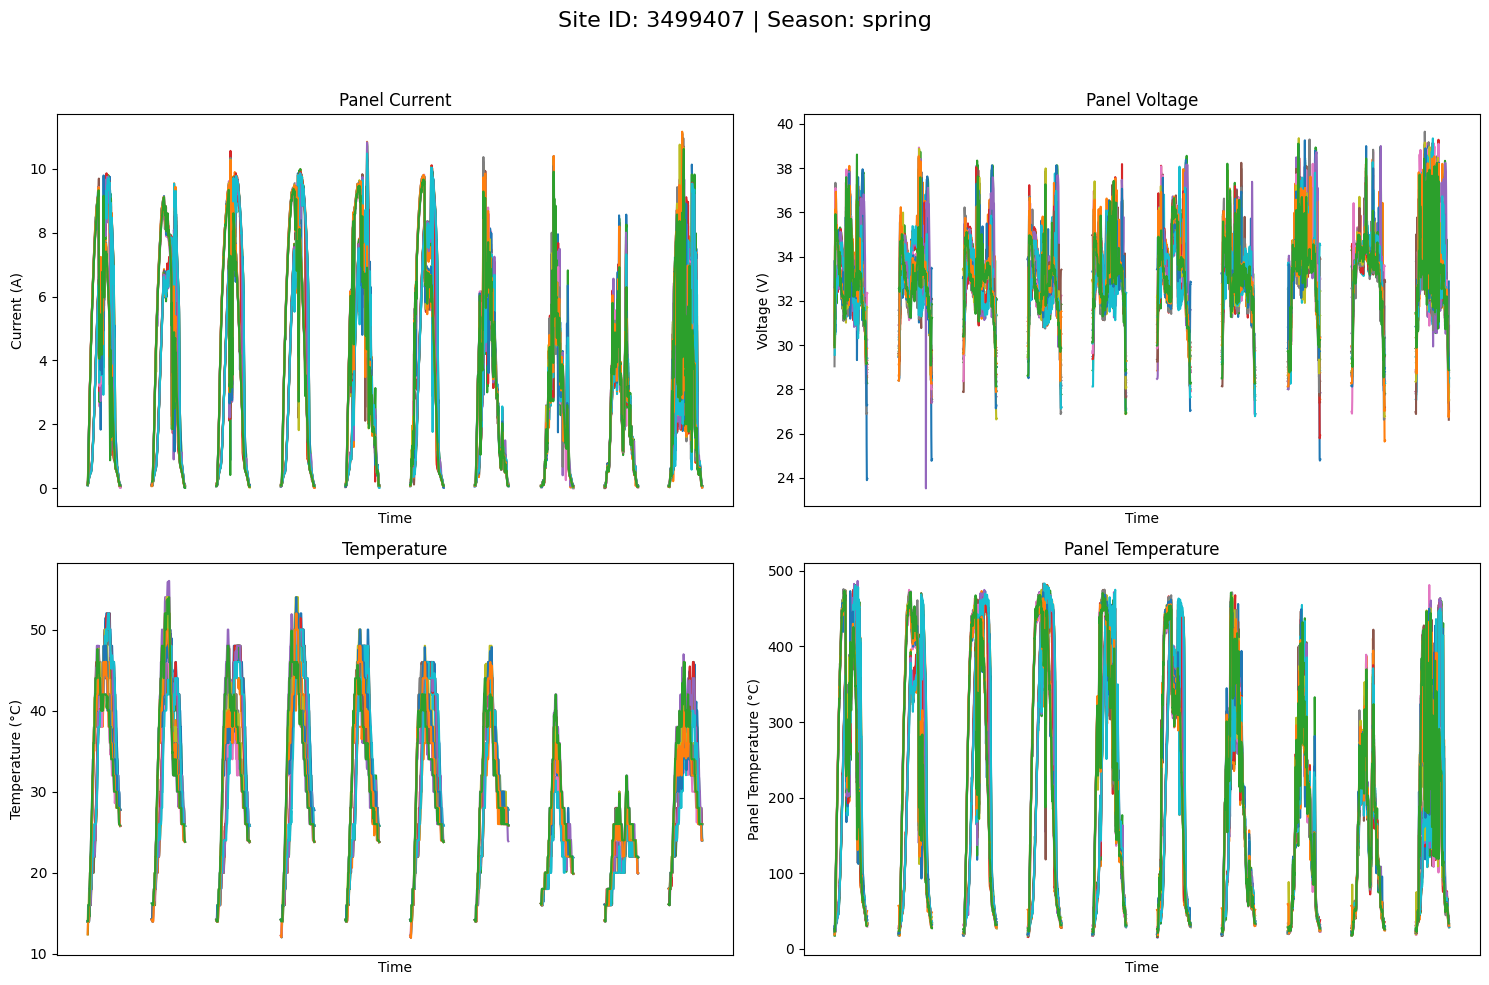

In [5]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 2x2 subplot for the data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Add a figure-level title with site ID and season
fig.suptitle(f"Site ID: {site_id} | Season: {season}", fontsize=16)

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'])
axs[0, 0].set_title('Panel Current')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Current (A)')
axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[0, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'])
axs[0, 1].set_title('Panel Voltage')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Voltage (V)')
axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all temperatures
for reporter_id in reporter_ids:
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'])
axs[1, 0].set_title('Temperature')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Temperature (°C)')
axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel temperatures
for reporter_id in reporter_ids:
    axs[1, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'])
axs[1, 1].set_title('Panel Temperature')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Panel Temperature (°C)')
axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()


#### 1.2.2.2. Exclude temperature

               Timestamp  panel_current_229481160  panel_voltage_229481160  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.151317                30.793239   
3    2024-09-20 06:00:00                 0.192742                30.953401   
4    2024-09-20 06:05:00                 0.235249                30.575567   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.121147                29.102454   
2734 2024-09-29 17:35:00                 0.100000                28.750000   
2735 2024-09-29 17:40:00                      NaN                      NaN   
2736 2024-09-29 17:45:00                      NaN                      NaN   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_229481160  panel_temperature_229481160  power

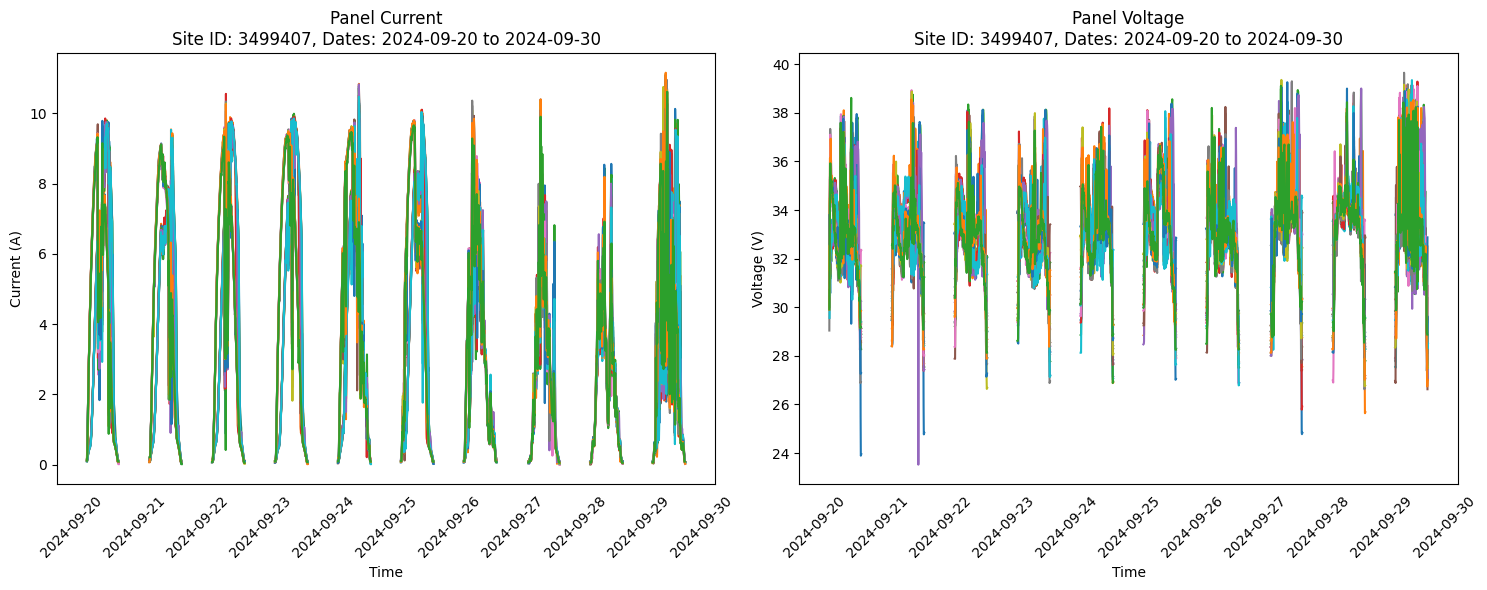

In [6]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 1x2 subplot for panel current and panel voltage
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Format the date range for the title
date_range_str = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'], label=f'Panel {reporter_id}')
axs[0].set_title(f'Panel Current\nSite ID: {site_id}, Dates: {date_range_str}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Current (A)')
axs[0].tick_params(axis='x', which='both', bottom=False, labelrotation=45)

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'], label=f'Panel {reporter_id}')
axs[1].set_title(f'Panel Voltage\nSite ID: {site_id}, Dates: {date_range_str}')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Voltage (V)')
axs[1].tick_params(axis='x', which='both', bottom=False, labelrotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### 1.2.2.3. Individual plots

               Timestamp  panel_current_229481160  panel_voltage_229481160  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.151317                30.793239   
3    2024-09-20 06:00:00                 0.192742                30.953401   
4    2024-09-20 06:05:00                 0.235249                30.575567   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.121147                29.102454   
2734 2024-09-29 17:35:00                 0.100000                28.750000   
2735 2024-09-29 17:40:00                      NaN                      NaN   
2736 2024-09-29 17:45:00                      NaN                      NaN   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_229481160  panel_temperature_229481160  power

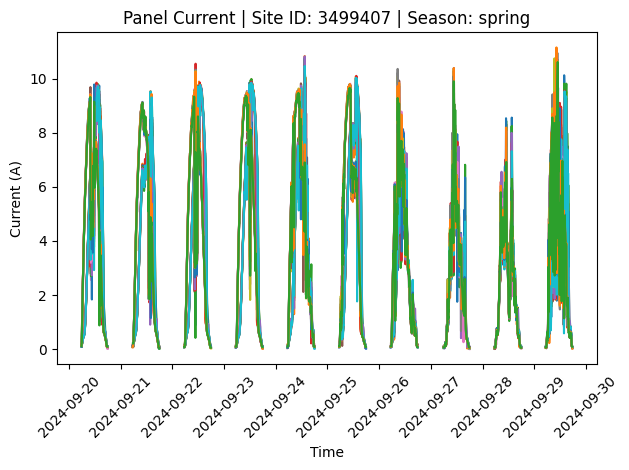

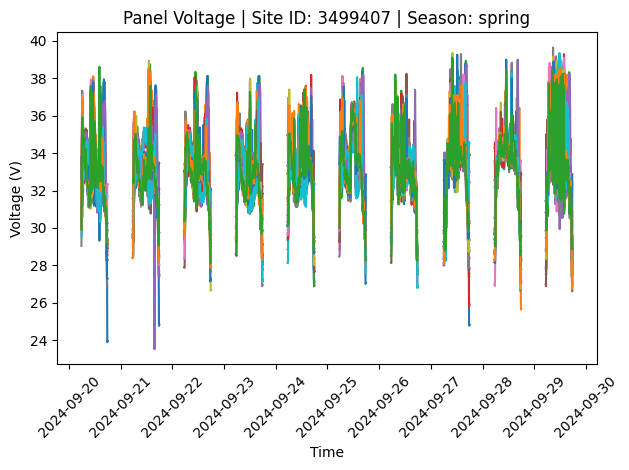

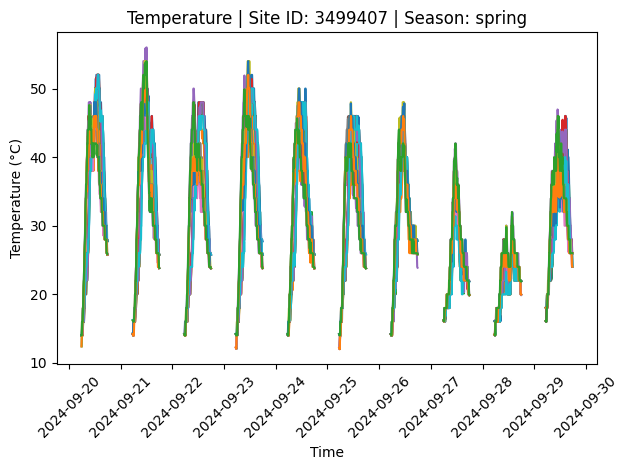

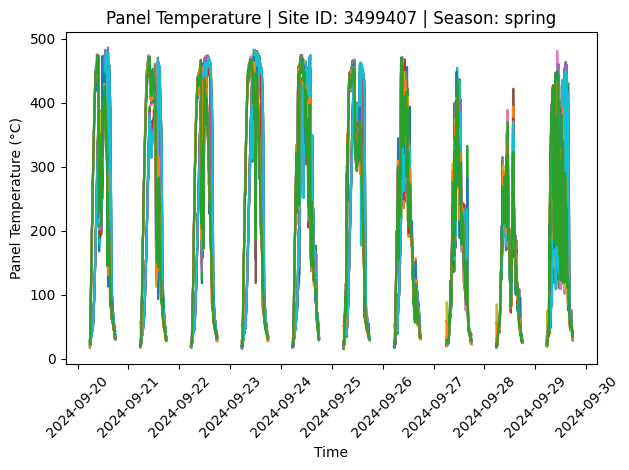

In [7]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Plot Panel Current in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Current | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Current (A)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Panel Voltage in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Voltage | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Temperature in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Temperature | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Panel Temperature in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Temperature | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Panel Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Series connection power calculation

## 2.1. One diode model data extraction

The data of module they get it from PVsyst database, which is CS6K - 315MS from CSI Solar. Therefore I go to PVsyst, find the module and extract n, Ncell, Rs, Rsh, then put it below.

In [8]:
# Parameters for the one-diode model
# if site_id == '347166':
#     ideality_factor = 1.0081
#     num_cells_series = 60
#     thermal_voltage_25C = 0.0258
#     series_resistance = 0.302
#     shunt_resistance = 400
# elif site_id == '1398284':
#     ideality_factor = 0.954526056
#     num_cells_series = 120
#     thermal_voltage_25C = 0.0258
#     series_resistance = 0.229
#     shunt_resistance = 300

# # Constants for vth calculation
boltzmann_constant = const.Boltzmann  # Boltzmann constant in J/K
electron_charge = const.e  # Elementary charge in C

## 2.2. Calculate IV curves from MPPT

### 2.2.1. Include the power output (debugging)

In [9]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrames to store the sum of I*V and total power for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])
# total_power_data = pd.DataFrame(columns=['Timestamp', 'Total Power (W)'])

# # Determine fixed x and y axis limits for all plots
# y_limit = (0, 13)
# x_limit = (0, 50)  # Assuming a reasonable range for combined voltages

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit[1], 100)

# for idx in range(len(merged_data)):
#     plt.figure(figsize=(10, 6))
#     sum_iv = 0
#     total_power = 0

#     for optimiser in reporter_ids:
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         optimiser_power = merged_data[f'power_{optimiser}']

#         is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
#                          np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

#         if not is_nan_or_zero:
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]
#             panel_power = optimiser_power.iloc[idx]

#             # Add to sums
#             sum_iv += panel_voltage * panel_current
#             total_power += panel_power

#             # IV Curve Calculation
#             vth = boltzmann_constant * (merged_data[f'panel_temperature_{optimiser}'].iloc[idx] + 273.15) / electron_charge
#             params = {
#                 'photocurrent': panel_current,
#                 'saturation_current': I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth),
#                 'resistance_series': series_resistance,
#                 'resistance_shunt': shunt_resistance,
#                 'nNsVth': ideality_factor * num_cells_series * vth,
#             }
#             voltage_iv = pvlib.pvsystem.v_from_i(current=currents, **params)

#             # Plot IV curve
#             plt.plot(voltage_iv, currents, label=f'IV Curve - {optimiser}')

#             # Plot MPPT Point
#             plt.plot(panel_voltage, panel_current, 'ro', label=f'MPPT - {optimiser}')

#     # Store data for this timestamp
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)
#     total_power_data = pd.concat([total_power_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Total Power (W)': [total_power]})], ignore_index=True)

#     # Finalize plot
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W, Total Power: {total_power:.2f} W')
#     plt.grid(True)
#     plt.xlim(x_limit)
#     plt.ylim(y_limit)

#     # Save the plot
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path)
#     plt.close()
#     image_files.append(file_path)



### 2.2.2. IV sum

In [10]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrame to store the sum of I*V for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit_module[1], 100)

# # Loop through each time step
# for idx in range(len(merged_data)):

#     # Create a new figure for each time step
#     plt.figure(figsize=(10, 6))

#     # Initialize a counter for the number of IV curves in the plot
#     iv_curve_count = 0
#     sum_iv = 0  # Initialize sum of I*V

#     # Skip this time step if all optimizers have NaN or zero values
#     all_nan_or_zero = all(
#         merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
#         merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
#         np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
#         np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
#         for optimiser in reporter_ids
#     )
#     if all_nan_or_zero:
#         print(f"Time step {idx} has NaN or zero values for all optimizers.")
#         continue

#     # Loop through each optimiser
#     for optimiser in reporter_ids:
#         # Extract the IV data from the optimiser for the current time step
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

#         # Check if there are any NaN or zero values in the current and voltage
#         is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
#                          np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

#         if is_nan_or_zero:
#             # If there are NaN or zero values, set voltage to zero for the entire current range
#             voltage = np.zeros_like(currents)
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
#             print(f"Time step {idx} has NaN or zero values for Optimizer {optimiser}.")
#         else:
#             # Convert panel temperature to Kelvin
#             panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

#             # Calculate vth dynamically or use the fixed value
#             if use_dynamic_vth:
#                 vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
#             else:
#                 vth = thermal_voltage_25C

#             # Extract voltage and current for the current time step
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]

#             # Add I*V to the sum for this optimizer
#             sum_iv += panel_voltage * panel_current

#             # Calculate the I0 at the operating point for the current time step
#             I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)

#             # Calculate the IL at the operating point for the current time step
#             IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

#             # Use the single diode model to calculate voltage for each current point
#             params = {
#                 'photocurrent': IL_op,  # Photocurrent (light-generated current)
#                 'saturation_current': I0_op,  # Saturation current
#                 'resistance_series': series_resistance,  # Series resistance
#                 'resistance_shunt': shunt_resistance,  # Shunt resistance
#                 'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
#             }

#             # Calculate voltage for each current point using the single diode model
#             voltage = pvlib.pvsystem.v_from_i(
#                 current=currents,
#                 photocurrent=params['photocurrent'],
#                 saturation_current=params['saturation_current'],
#                 resistance_series=params['resistance_series'],
#                 resistance_shunt=params['resistance_shunt'],
#                 nNsVth=params['nNsVth']
#             )

#             # Plot the IV curve for the current time step on the same axis
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')

#             # Mark the panel voltage and panel current at this point
#             plt.plot(panel_voltage, panel_current, 'ro')  # Mark with a red circle

#         # Increment the counter for each plotted IV curve
#         iv_curve_count += 1

#     # Print out the number of IV curves in the plot
#     print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

#     # Store the sum of I*V in the DataFrame
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

#     # Set consistent x and y axis limits for all plots
#     plt.xlim(x_limit_module)
#     plt.ylim(y_limit_module)

#     # Finalize the plot for the current time step
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W')
#     plt.grid(True)

#     # Save the plot as a PNG file with "summer/winter" and site_id in the file name
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path)
#     plt.close()

#     # Add the file path to the list for GIF creation
#     image_files.append(file_path)

# # Save the sum of I*V data to an Excel file
# excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
# iv_sum_data.to_excel(excel_path, index=False)
# print(f"Excel file saved as: {excel_path}")

# # Create a GIF from the saved images with slower speed and loop indefinitely
# gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
# with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
#     for filename in image_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as '{gif_path}'")


### 2.2.3. With Raw data

In [12]:
# ============================
# Option to choose optimizers to run:
# If selected_optimizers is defined as a list (e.g. below), only those optimizers will be processed.
# If it is set to None, the code will run for all optimizers (i.e. all IDs in reporter_ids).
# ============================
# selected_optimizers = ['241622244', '241622317', '241622327', '249776740']  
# To run for all optimizers, simply set:
selected_optimizers = None

# Determine which optimizers to run:
if selected_optimizers is not None:
    optimizers_to_run = [opt for opt in reporter_ids if opt in selected_optimizers]
else:
    optimizers_to_run = reporter_ids

# Get the current timestamp when the code is run
import datetime
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF (for reconstructed IV plots)
import matplotlib.pyplot as plt
import imageio
import numpy as np
import pandas as pd
image_files = []

# DataFrame to store the sum of I*V for each timestamp
iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit_module[1], 100)

# Loop through each time step
for idx in range(len(merged_data)):
    # Skip this time step if all optimizers have NaN or zero values
    all_nan_or_zero = all(
        merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
        merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
        np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
        np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
        for optimiser in reporter_ids
    )
    if all_nan_or_zero:
        print(f"Time step {idx} has NaN or zero values for all optimizers.")
        continue

    # ----- Reconstructed IV Plot -----
    plt.figure(figsize=(10, 6))
    iv_curve_count = 0
    sum_iv = 0  # Initialize sum of I*V

    # Loop through each optimizer in the selected list
    for optimiser in optimizers_to_run:
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # in °C

        is_nan_or_zero = (
            optimiser_voltage.iloc[idx] == 0 or 
            optimiser_current.iloc[idx] == 0 or 
            np.isnan(optimiser_voltage.iloc[idx]) or 
            np.isnan(optimiser_current.iloc[idx])
        )

        if is_nan_or_zero:
            # If data is not valid, plot zeros for the current range
            voltage = np.zeros_like(currents)
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
            print(f"Time step {idx} has NaN or zero values for Optimizer {optimiser}.")
        else:
            # Convert panel temperature to Kelvin
            panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

            # Calculate vth dynamically or use fixed value
            if use_dynamic_vth:
                vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
            else:
                vth = thermal_voltage_25C

            panel_voltage = optimiser_voltage.iloc[idx]
            panel_current = optimiser_current.iloc[idx]
            sum_iv += panel_voltage * panel_current

            # Calculate I0 and IL at the operating point
            I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
            IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

            params = {
                'photocurrent': IL_op,
                'saturation_current': I0_op,
                'resistance_series': series_resistance,
                'resistance_shunt': shunt_resistance,
                'nNsVth': ideality_factor * num_cells_series * vth
            }

            # Compute reconstructed voltage curve
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # Plot reconstructed IV curve
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
            # Mark the measured operating point (MPPT)
            plt.plot(panel_voltage, panel_current, 'ro')

        iv_curve_count += 1

    timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
    iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

    plt.xlim(x_limit_module)
    plt.ylim(y_limit_module)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    # Updated title with site ID
    plt.title(f'IV Curves at {timestamp_title} for Site {site_id}\nSum of I*V: {sum_iv:.2f} W')
    plt.grid(True)
    
    # Place the legend outside the plot with 4 columns
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=4)

    # Save the reconstructed IV plot
    file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    image_files.append(file_path)
    print(f"Reconstructed IV plot saved: {file_path}")

    # ----- Raw Data Plot -----
    # Create a new figure for raw measured data
    plt.figure(figsize=(10, 6))
    
    # Loop through each optimizer in the selected list and plot the raw measurement (single point)
    for optimiser in optimizers_to_run:
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        # Check if valid data exists
        is_nan_or_zero = (
            optimiser_voltage.iloc[idx] == 0 or 
            optimiser_current.iloc[idx] == 0 or 
            np.isnan(optimiser_voltage.iloc[idx]) or 
            np.isnan(optimiser_current.iloc[idx])
        )
        if not is_nan_or_zero:
            panel_voltage = optimiser_voltage.iloc[idx]
            panel_current = optimiser_current.iloc[idx]
            plt.plot(panel_voltage, panel_current, 'ro', markersize=8, label=f'Optimizer {optimiser}')
        else:
            # Optionally, mark missing data differently
            plt.plot(0, 0, 'kx', label=f'Optimizer {optimiser} (no data)')

    plt.xlim(x_limit_module)
    plt.ylim(y_limit_module)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    # Updated title with site ID
    plt.title(f'Raw IV Data at {timestamp_title} for Site {site_id}')
    plt.grid(True)
    # Save the raw data plot with a modified filename
    raw_file_path = os.path.join(output_dir, f'iv_curve_raw_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(raw_file_path, bbox_inches='tight')
    plt.close()
    print(f"Raw IV plot saved: {raw_file_path}")

# Save the sum of I*V data to an Excel file
excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
iv_sum_data.to_excel(excel_path, index=False)
print(f"Excel file saved as: {excel_path}")

# Create a GIF from the reconstructed IV images with slower speed and loop indefinitely
gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as '{gif_path}'")


Time step 0 has NaN or zero values for Optimizer 229481160.
Time step 0 has NaN or zero values for Optimizer 229481161.
Time step 0 has NaN or zero values for Optimizer 229481162.
Time step 0 has NaN or zero values for Optimizer 229481163.
Time step 0 has NaN or zero values for Optimizer 229481164.
Time step 0 has NaN or zero values for Optimizer 229481165.
Time step 0 has NaN or zero values for Optimizer 229481166.
Time step 0 has NaN or zero values for Optimizer 229481168.
Time step 0 has NaN or zero values for Optimizer 229481169.
Time step 0 has NaN or zero values for Optimizer 229481170.
Time step 0 has NaN or zero values for Optimizer 229481171.
Time step 0 has NaN or zero values for Optimizer 229481172.
Time step 0 has NaN or zero values for Optimizer 229481173.
Time step 0 has NaN or zero values for Optimizer 229481174.
Time step 0 has NaN or zero values for Optimizer 229481205.
Time step 0 has NaN or zero values for Optimizer 229481207.


C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\3340251422.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)


Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250507_095017_spring_3499407\iv_curve_2024-09-20_05-45-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250507_095017_spring_3499407\iv_curve_raw_2024-09-20_05-45-00.png
Time step 1 has NaN or zero values for Optimizer 229481160.
Time step 1 has NaN or zero values for Optimizer 229481161.
Time step 1 has NaN or zero values for Optimizer 229481165.
Time step 1 has NaN or zero values for Optimizer 229481171.
Time step 1 has NaN or zero values for Optimizer 229481174.
Reconstructed IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250507_095017_spring_3499407\iv_curve_2024-09-20_05-50-00.png
Raw IV plot saved: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250507_095017_spring_3499407\iv_curve_raw_2024-09-20_05-50

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\3340251422.py:181: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i/iv_curve_plots_20250507_095017_spring_3499407\iv_curves_spring_3499407.gif'


## 2.3. Combine IV curves in series with ideal bypass

In [13]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# DataFrame to store the maximum power points at each timestamp
max_power_df_combined = pd.DataFrame(columns=['Timestamp', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# DataFrame to store Pmppt for each timestamp
pmppt_data = pd.DataFrame(columns=['Timestamp', 'Pmppt (W)'])

# DataFrame to store J0 calculated from each optimiser
j0_df = pd.DataFrame(columns=['Timestamp', 'Optimizer', 'J0'])

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit_inverter[1], 100)

# Loop through each timestamp
for idx in range(len(merged_data)):

    # Create a new figure for each timestamp
    plt.figure(figsize=(10, 6))

    # Initialize array to store summed voltages for combined IV curve
    combined_voltage = np.zeros_like(currents)

    # Initialize a flag to track if any optimizer data is valid for this timestamp
    valid_data_found = False

    # Get the current timestamp
    current_timestamp = pd.to_datetime(merged_data['Timestamp'].iloc[idx])

    # Loop through each optimizer
    for optimiser in reporter_ids:

        # Extract the IV data from the optimizer for the current timestamp
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

        # Skip if data is NaN or zero, and record NaN for J0
        if (np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx]) or
                optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0):
            print(f"NaN or zero found in voltage/current at timestamp {current_timestamp}, optimizer {optimiser}")
            j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [current_timestamp],
                                                    'Optimizer': [optimiser],
                                                    'J0': [np.nan]})], ignore_index=True)
            continue

        # Mark that valid data is found
        valid_data_found = True

        # Convert panel temperature to Kelvin
        panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

        # Calculate vth dynamically or use the fixed value
        if use_dynamic_vth:
            vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
        else:
            vth = thermal_voltage_25C

        # Extract voltage and current for the current timestamp
        panel_voltage = optimiser_voltage.iloc[idx]
        panel_current = optimiser_current.iloc[idx]

        # Calculate I0 (J0) and IL for the optimizer at this timestamp
        I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
        # Append J0 for this optimizer
        j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [current_timestamp],
                                                'Optimizer': [optimiser],
                                                'J0': [I0_op]})], ignore_index=True)
        IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

        # Use the single diode model to calculate voltage for each current point
        params = {
            'photocurrent': IL_op,  # Photocurrent (light-generated current)
            'saturation_current': I0_op,  # Saturation current (J0)
            'resistance_series': series_resistance,  # Series resistance
            'resistance_shunt': shunt_resistance,  # Shunt resistance
            'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
        }

        # Calculate voltage for each current point using the single diode model
        voltage = pvlib.pvsystem.v_from_i(
            current=currents,
            **params
        )

        # Handle currents greater than Isc by setting voltage to 0
        results = pvlib.pvsystem.singlediode(**params)
        isc = results['i_sc']
        voltage = np.where(currents > isc, 0, voltage)

        # Add the voltage to the combined voltage array
        combined_voltage += voltage

    # If no valid data was found for this timestamp, skip plotting and saving
    if not valid_data_found:
        print(f"No valid data for any optimizer at timestamp {current_timestamp}, skipping.")
        continue

    # Calculate power for each voltage point using the combined IV curve
    power = combined_voltage * currents

    # Find the index of the maximum power point
    max_power_idx = np.argmax(power)
    max_voltage = combined_voltage[max_power_idx]
    max_current = currents[max_power_idx]
    max_power = power[max_power_idx]

    # Find Isc and Voc for the combined curve
    isc_combined = currents[np.where(combined_voltage > 0)[0][-1]]
    voc_combined = combined_voltage[np.where(currents == 0)[0][0]]

    # Create a DataFrame for the current max power point
    max_power_point = pd.DataFrame({
        'Timestamp': [current_timestamp],
        'Max Voltage (V)': [max_voltage],
        'Max Current (A)': [max_current],
        'Max Power (W)': [max_power],
        'Voc (V)': [voc_combined],
        'Isc (A)': [isc_combined]
    })

    max_power_df_combined = pd.concat([max_power_df_combined, max_power_point], ignore_index=True)

    # Add Pmppt to the pmppt_data DataFrame
    pmppt_data = pd.concat([pmppt_data, pd.DataFrame({'Timestamp': [current_timestamp],
                                                      'Pmppt (W)': [max_power]})], ignore_index=True)

    # Plot the combined IV curve
    plt.plot(combined_voltage, currents, label='Combined IV Curve')
    plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')
    plt.plot(voc_combined, 0, 'go', label='Voc')
    plt.plot(0, isc_combined, 'bo', label='Isc')

    # Add PMPPT, VMPPT, and IMPPT to the title
    plt.title(
        f"Combined IV Curve at {current_timestamp}\n"
        f"Pmppt: {max_power:.2f} W, Vmppt: {max_voltage:.2f} V, Imppt: {max_current:.2f} A"
    )

    plt.xlim(x_limit_inverter)
    plt.ylim(y_limit_inverter)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.grid(True)
    plt.legend()

    # Save the plot as a PNG file
    file_path = os.path.join(output_dir, f'combined_iv_curve_{current_timestamp.strftime("%Y%m%d_%H%M%S")}.png')
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Save the Pmppt data to an Excel file
excel_file = os.path.join(output_dir, 'pmppt_data.xlsx')
pmppt_data.to_excel(excel_file, index=False)
print(f"Excel file saved as: {excel_file}")

# Create GIF
gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)
print(f"GIF saved as: {gif_path}")

# Export J0 data to a CSV file with optimizer IDs as column names
j0_pivot = j0_df.pivot(index='Timestamp', columns='Optimizer', values='J0')
j0_csv_path = os.path.join(output_dir, 'j0_data.csv')
j0_pivot.to_csv(j0_csv_path)
print(f"CSV file saved as: {j0_csv_path}")


NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481160
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481161
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481162
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481163
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481164
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481165
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481166
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481168
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481169
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481170
NaN or zero found in voltage/current at timestamp 2024-09-20 05:45:00, optimizer 229481171

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\1928352770.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [current_timestamp],
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\1928352770.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [current_timestamp],
C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\1928352770.py:128: FutureWarning: The behavior of DataFrame conca

NaN or zero found in voltage/current at timestamp 2024-09-20 05:50:00, optimizer 229481160
NaN or zero found in voltage/current at timestamp 2024-09-20 05:50:00, optimizer 229481161
NaN or zero found in voltage/current at timestamp 2024-09-20 05:50:00, optimizer 229481165
NaN or zero found in voltage/current at timestamp 2024-09-20 05:50:00, optimizer 229481171
NaN or zero found in voltage/current at timestamp 2024-09-20 05:50:00, optimizer 229481174
NaN or zero found in voltage/current at timestamp 2024-09-20 05:55:00, optimizer 229481171
NaN or zero found in voltage/current at timestamp 2024-09-20 17:50:00, optimizer 229481167
NaN or zero found in voltage/current at timestamp 2024-09-20 17:50:00, optimizer 229481168
NaN or zero found in voltage/current at timestamp 2024-09-20 17:50:00, optimizer 229481205
NaN or zero found in voltage/current at timestamp 2024-09-20 17:50:00, optimizer 229481370
NaN or zero found in voltage/current at timestamp 2024-09-20 17:50:00, optimizer 229481869

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\1928352770.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481167
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481168
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481169
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481170
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481171
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481172
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481173
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481174
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481175
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481204
NaN or zero found in voltage/current at timestamp 2024-09-20 19:55:00, optimizer 229481205

C:\Users\z5183876\AppData\Local\Temp\ipykernel_23804\1928352770.py:170: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\combined_iv_curves.gif
CSV file saved as: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\j0_data.csv


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# 3. Power comparison

## 3.1. Power comparison

### 3.1.1. Sum over whole period

Combined data exported to: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\combined_data_spring_3499407.xlsx
The lengths of Sum of I*V and Pmppt are the same.
Sum of I*V Energy: 4430639.62 W
Pmppt Energy: 3696959.43 W
Sum mismatch: 16.56%
Plot exported to: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\pmppt_vs_sum_iv.png


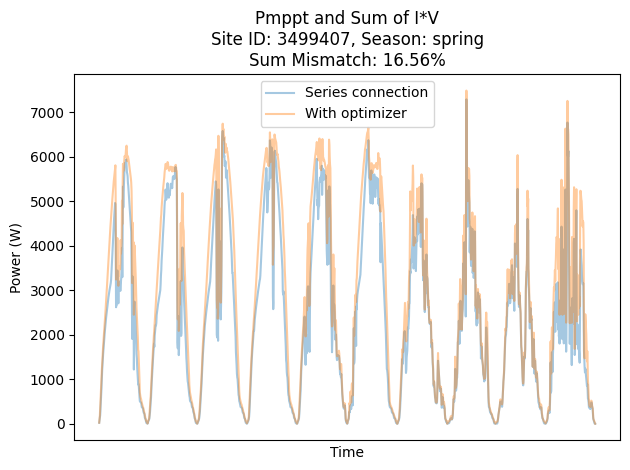

In [14]:
# Merge the pmppt_data with the iv_sum_data
combined_data = pd.concat([iv_sum_data, pmppt_data['Pmppt (W)']], axis=1)

# Add season and site ID columns to the combined data
combined_data['Season'] = season
combined_data['Site ID'] = site_id

# Export the combined data to an Excel file with season and site ID in the file name
excel_file = os.path.join(output_dir, f'combined_data_{season}_{site_id}.xlsx')
combined_data.to_excel(excel_file, index=False)

print(f"Combined data exported to: {excel_file}")

# Calculate the total energy of Sum of I*V and Pmppt
sum_iv_E = combined_data['Sum of I*V (W)'].sum()
pmppt_E = combined_data['Pmppt (W)'].sum()
sum_mismatch = (sum_iv_E - pmppt_E) / sum_iv_E

# Check if the lengths of Sum of I*V and Pmppt are the same
if len(combined_data['Sum of I*V (W)']) == len(combined_data['Pmppt (W)']):
    print("The lengths of Sum of I*V and Pmppt are the same.")
else:
    print("Warning: The lengths of Sum of I*V and Pmppt are not the same!")

# Print the total energy for both
print(f"Sum of I*V Energy: {sum_iv_E:.2f} W")
print(f"Pmppt Energy: {pmppt_E:.2f} W")

# Print the mean mismatch in percentage with 2 decimal places
print(f"Sum mismatch: {sum_mismatch * 100:.2f}%")

# Plot the Pmppt and Sum of I*V
fig, ax = plt.subplots()
ax.plot(combined_data['Timestamp'], combined_data['Pmppt (W)'], label='Series connection', alpha=0.4)
ax.plot(combined_data['Timestamp'], combined_data['Sum of I*V (W)'], label='With optimizer', alpha=0.4)
ax.set_xlabel('Time')
ax.set_ylabel('Power (W)')
# Include season and site ID in the title
ax.set_title(f'Pmppt and Sum of I*V\nSite ID: {site_id}, Season: {season}\nSum Mismatch: {sum_mismatch * 100:.2f}%')
ax.legend()
# Remove xticks
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.tight_layout()

# Save the plot to a PNG file
plot_file = os.path.join(output_dir, 'pmppt_vs_sum_iv.png')
fig.savefig(plot_file)
print(f"Plot exported to: {plot_file}")

plt.show()

### 3.1.2. Aggregate over each day

Date: 2024-09-20
Maximum IV Power: 6245.30 W (Exceeds 3000 W: True)
Daily Energy MPPT: 32382.59 Wh
Daily Energy IV: 39822.59 Wh
Daily Mismatch: 18.68%

Plot saved for 2024-09-20: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-20_Site_ID_3499407_Season_spring_E_MPPT_3238259_Wh_E_IV_3982259_Wh_Max_IV_Power_624530_W_Mismatch_1868.png



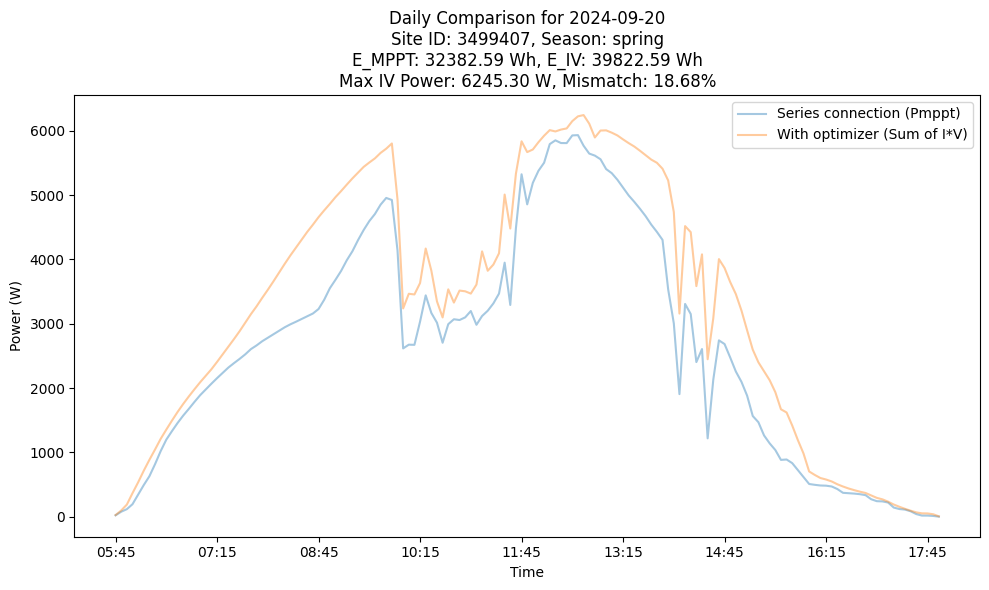

Date: 2024-09-21
Maximum IV Power: 5877.15 W (Exceeds 3000 W: True)
Daily Energy MPPT: 33298.87 Wh
Daily Energy IV: 40250.42 Wh
Daily Mismatch: 17.27%

Plot saved for 2024-09-21: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-21_Site_ID_3499407_Season_spring_E_MPPT_3329887_Wh_E_IV_4025042_Wh_Max_IV_Power_587715_W_Mismatch_1727.png



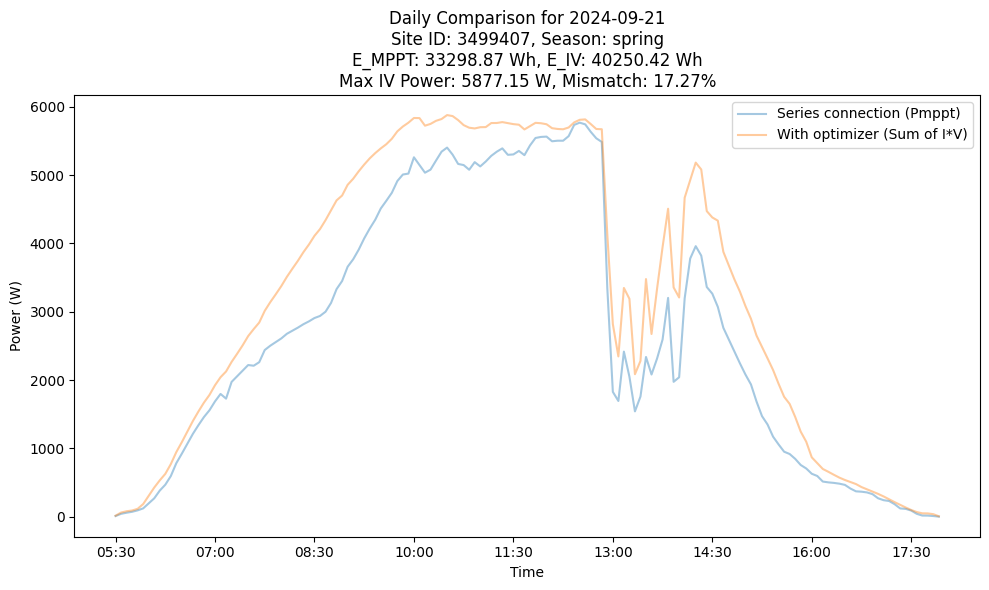

Date: 2024-09-22
Maximum IV Power: 6738.42 W (Exceeds 3000 W: True)
Daily Energy MPPT: 34130.37 Wh
Daily Energy IV: 41789.36 Wh
Daily Mismatch: 18.33%

Plot saved for 2024-09-22: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-22_Site_ID_3499407_Season_spring_E_MPPT_3413037_Wh_E_IV_4178936_Wh_Max_IV_Power_673842_W_Mismatch_1833.png



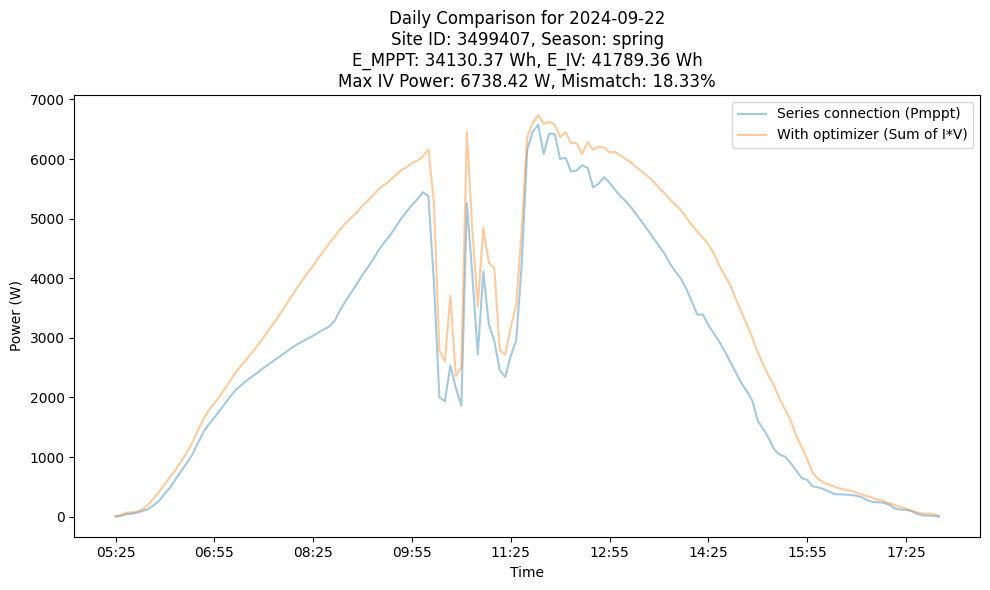

Date: 2024-09-23
Maximum IV Power: 6543.44 W (Exceeds 3000 W: True)
Daily Energy MPPT: 37208.12 Wh
Daily Energy IV: 44828.78 Wh
Daily Mismatch: 17.00%

Plot saved for 2024-09-23: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-23_Site_ID_3499407_Season_spring_E_MPPT_3720812_Wh_E_IV_4482878_Wh_Max_IV_Power_654344_W_Mismatch_1700.png



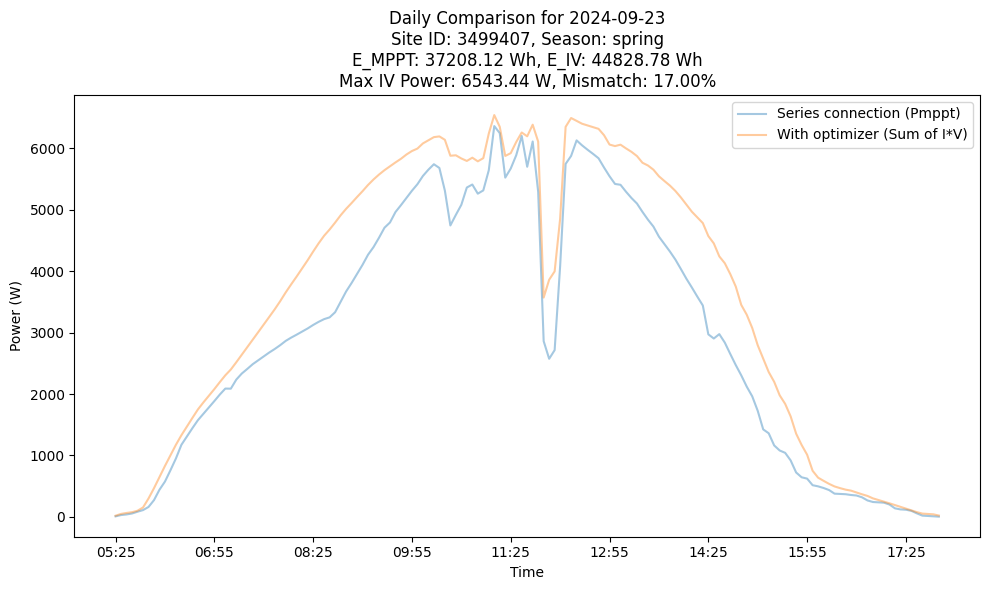

Date: 2024-09-24
Maximum IV Power: 6406.46 W (Exceeds 3000 W: True)
Daily Energy MPPT: 36174.15 Wh
Daily Energy IV: 42973.44 Wh
Daily Mismatch: 15.82%

Plot saved for 2024-09-24: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-24_Site_ID_3499407_Season_spring_E_MPPT_3617415_Wh_E_IV_4297344_Wh_Max_IV_Power_640646_W_Mismatch_1582.png



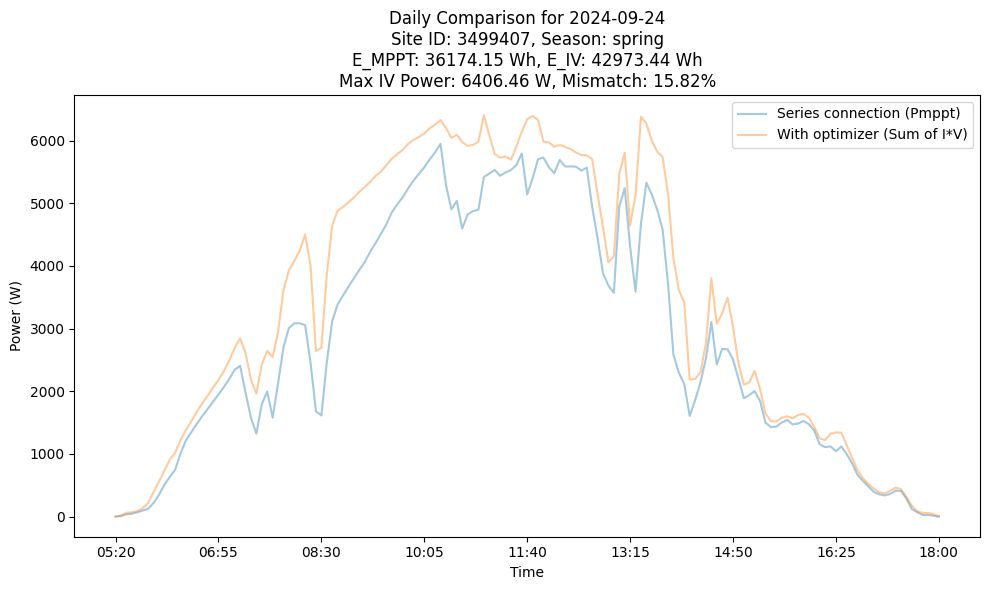

Date: 2024-09-25
Maximum IV Power: 6651.14 W (Exceeds 3000 W: True)
Daily Energy MPPT: 37257.99 Wh
Daily Energy IV: 44930.13 Wh
Daily Mismatch: 17.08%

Plot saved for 2024-09-25: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-25_Site_ID_3499407_Season_spring_E_MPPT_3725799_Wh_E_IV_4493013_Wh_Max_IV_Power_665114_W_Mismatch_1708.png



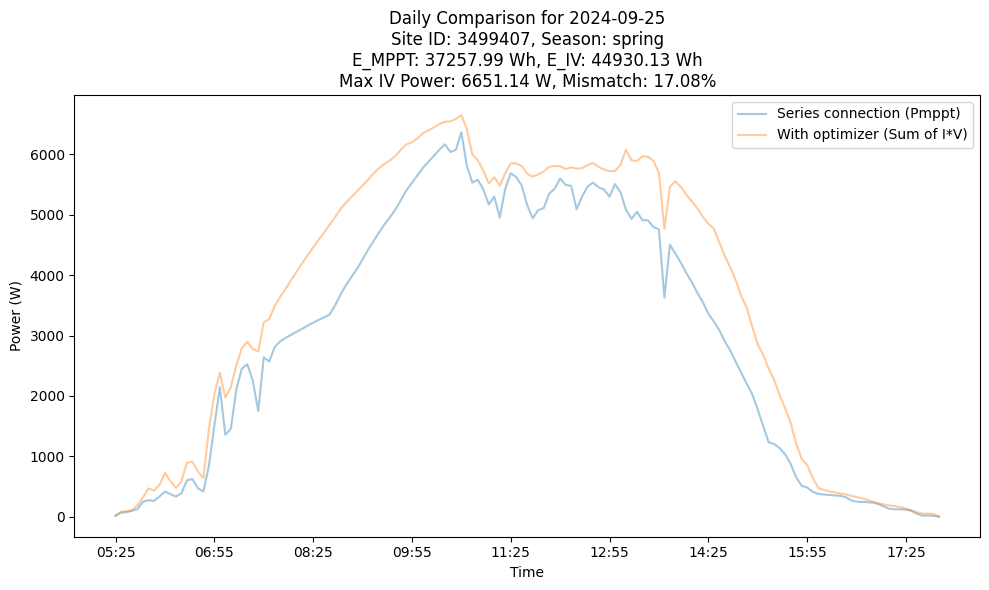

Date: 2024-09-26
Maximum IV Power: 5798.99 W (Exceeds 3000 W: True)
Daily Energy MPPT: 26707.57 Wh
Daily Energy IV: 30722.17 Wh
Daily Mismatch: 13.07%

Plot saved for 2024-09-26: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-26_Site_ID_3499407_Season_spring_E_MPPT_2670757_Wh_E_IV_3072217_Wh_Max_IV_Power_579899_W_Mismatch_1307.png



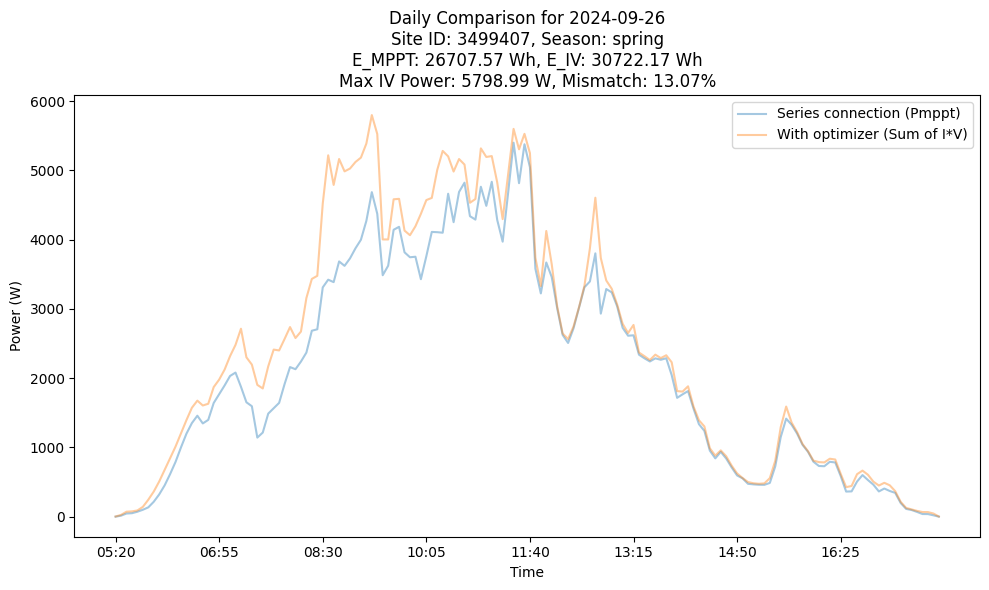

Date: 2024-09-27
Maximum IV Power: 7481.68 W (Exceeds 3000 W: True)
Daily Energy MPPT: 23610.67 Wh
Daily Energy IV: 26030.73 Wh
Daily Mismatch: 9.30%

Plot saved for 2024-09-27: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-27_Site_ID_3499407_Season_spring_E_MPPT_2361067_Wh_E_IV_2603073_Wh_Max_IV_Power_748168_W_Mismatch_930.png



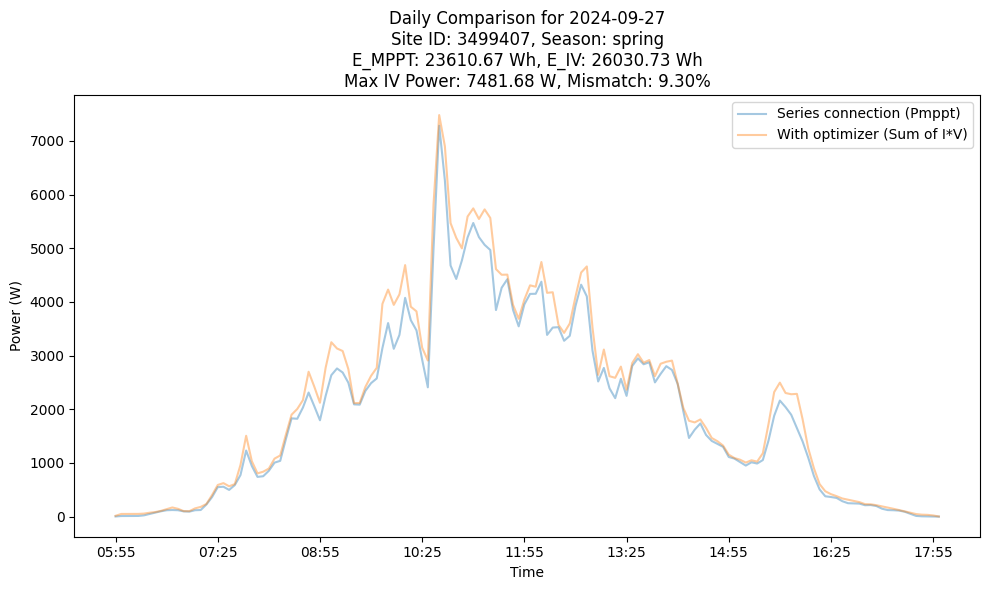

Date: 2024-09-28
Maximum IV Power: 6032.47 W (Exceeds 3000 W: True)
Daily Energy MPPT: 22198.52 Wh
Daily Energy IV: 23869.58 Wh
Daily Mismatch: 7.00%



Plot saved for 2024-09-28: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-28_Site_ID_3499407_Season_spring_E_MPPT_2219852_Wh_E_IV_2386958_Wh_Max_IV_Power_603247_W_Mismatch_700.png



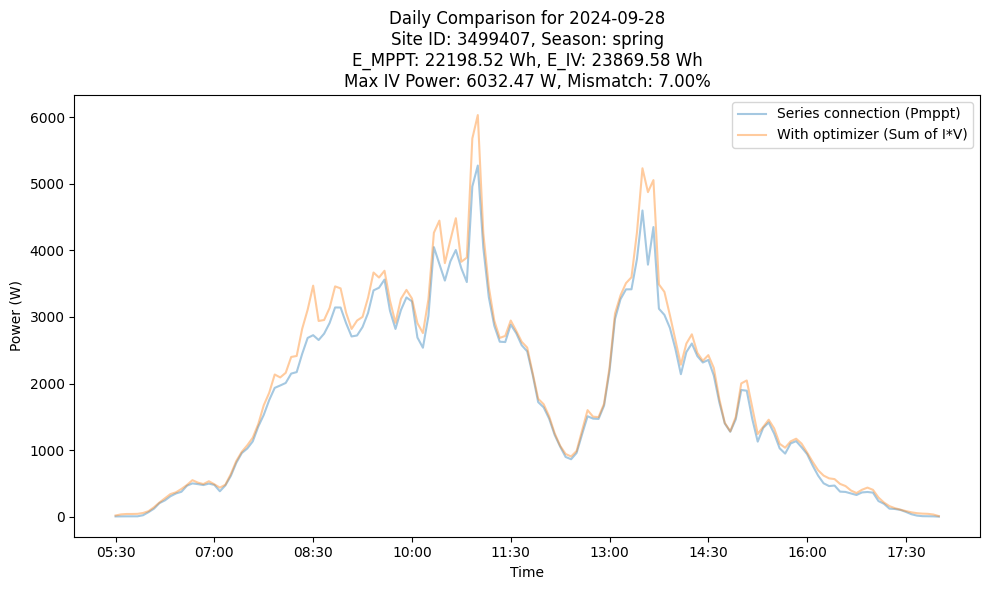

Date: 2024-09-29
Maximum IV Power: 7249.94 W (Exceeds 3000 W: True)
Daily Energy MPPT: 25111.11 Wh
Daily Energy IV: 34002.77 Wh
Daily Mismatch: 26.15%

Plot saved for 2024-09-29: C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250507_102414_spring_3499407\Daily_Comparison_for_2024-09-29_Site_ID_3499407_Season_spring_E_MPPT_2511111_Wh_E_IV_3400277_Wh_Max_IV_Power_724994_W_Mismatch_2615.png



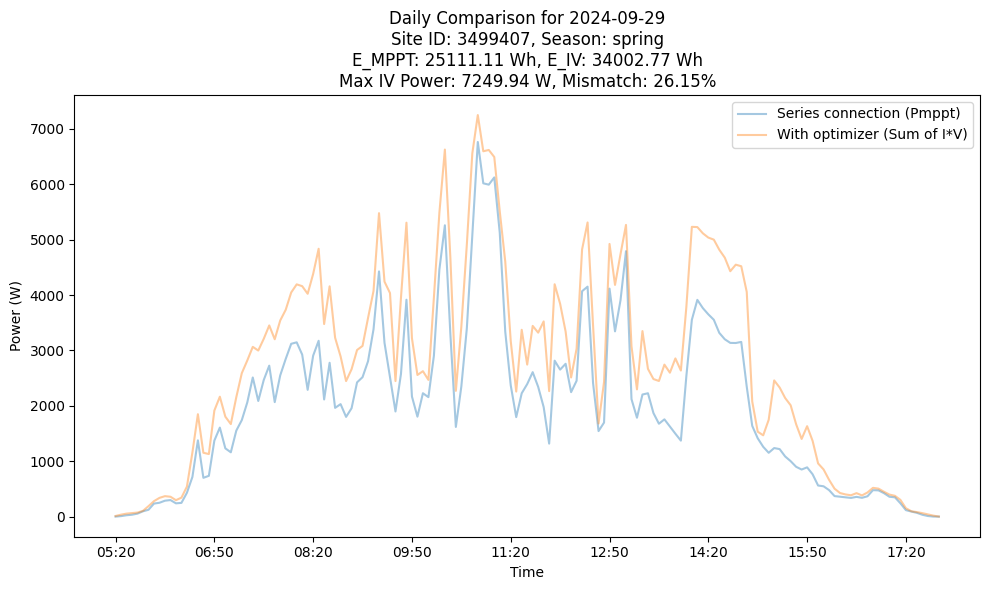

Weighted Average Daily Mismatch: 16.56%


In [15]:
# perform filter
perform_filter = False

# Ensure Timestamp is in datetime format
combined_data['Timestamp'] = pd.to_datetime(combined_data['Timestamp'])

# Add a Date column to group by day
combined_data['Date'] = combined_data['Timestamp'].dt.date

# Calculate daily energy (convert power to energy in Wh)
combined_data['Energy_IV (Wh)'] = combined_data['Sum of I*V (W)'] * (5 / 60)  # Convert 5-min data to Wh
combined_data['Energy_MPPT (Wh)'] = combined_data['Pmppt (W)'] * (5 / 60)

# Group by date and calculate daily sums
daily_data = combined_data.groupby('Date')[['Energy_IV (Wh)', 'Energy_MPPT (Wh)']].sum()

# Initialize variables for weighted average calculation
weighted_sum_difference = 0
total_energy = 0

import re  # To clean title text for file names

# Iterate over each day to calculate differences, check conditions, and plot
for date, daily_row in daily_data.iterrows():
    energy_iv_daily = daily_row['Energy_IV (Wh)']
    energy_mppt_daily = daily_row['Energy_MPPT (Wh)']

    # Calculate daily mismatch
    daily_mismatch = (energy_iv_daily - energy_mppt_daily) / energy_iv_daily

    # Filter data for the current day
    day_data = combined_data[combined_data['Date'] == date]

    # Calculate the maximum IV power for the day
    max_iv_power = day_data['Sum of I*V (W)'].max()

    # Only include days with max IV power > 3000 W in weighted mismatch calculation
    if perform_filter:
        if max_iv_power > 3000:
            weighted_sum_difference += daily_mismatch * energy_iv_daily  # Weight by daily energy
            total_energy += energy_iv_daily  # Use IV energy for weighting
    else:
        weighted_sum_difference += daily_mismatch * energy_iv_daily  # Weight by daily energy
        total_energy += energy_iv_daily  # Use IV energy for weighting

    # Log results
    exceeds_3000W = max_iv_power > 3000
    print(f"Date: {date}")
    print(f"Maximum IV Power: {max_iv_power:.2f} W (Exceeds 3000 W: {exceeds_3000W})")
    print(f"Daily Energy MPPT: {energy_mppt_daily:.2f} Wh")
    print(f"Daily Energy IV: {energy_iv_daily:.2f} Wh")
    print(f"Daily Mismatch: {daily_mismatch * 100:.2f}%\n")

    # Plot the comparison for the day
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(day_data['Timestamp'], day_data['Pmppt (W)'], label='Series connection (Pmppt)', alpha=0.4)
    ax.plot(day_data['Timestamp'], day_data['Sum of I*V (W)'], label='With optimizer (Sum of I*V)', alpha=0.4)
    ax.set_xlabel('Time')
    ax.set_ylabel('Power (W)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format x-axis as hours
    ax.set_xticks(day_data['Timestamp'][::len(day_data) // 8])  # Set fewer ticks on x-axis

    # Include daily details in the title
    plot_title = (
        f"Daily Comparison for {date}\n"
        f"Site ID: {site_id}, Season: {season}\n"
        f"E_MPPT: {energy_mppt_daily:.2f} Wh, E_IV: {energy_iv_daily:.2f} Wh\n"
        f"Max IV Power: {max_iv_power:.2f} W, Mismatch: {daily_mismatch * 100:.2f}%"
    )
    ax.set_title(plot_title)
    ax.legend()
    plt.tight_layout()

    # Generate a safe file name from the title
    safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_').replace('\n', '_')
    plot_file = os.path.join(output_dir, f"{safe_title}.png")

    # Save the plot for each day
    fig.savefig(plot_file)
    print(f"Plot saved for {date}: {plot_file}\n")

    plt.show()

# Calculate the weighted average of daily percentage differences
weighted_avg_mismatch = weighted_sum_difference / total_energy

# Print the weighted average mismatch
print(f"Weighted Average Daily Mismatch: {weighted_avg_mismatch * 100:.2f}%")


## 3.2. Check by timestamp

In [16]:
# # input the timestamp to check
# timestamp = '2024-01-19 11:20:00'

# # extract the Pmppt and I*V sum for the timestamp from the combined data
# pmppt = combined_data.loc[combined_data['Timestamp'] == timestamp, 'Pmppt (W)'].values[0]
# sum_iv = combined_data.loc[combined_data['Timestamp'] == timestamp, 'Sum of I*V (W)'].values[0]

# # calculate the mismatch
# mismatch = 1 - pmppt / sum_iv

# # print the result
# print(f"Timestamp: {timestamp}")
# print(f"Pmppt: {pmppt:.2f} W")
# print(f"Sum of I*V: {sum_iv:.2f} W")
# print(f"Mismatch: {mismatch * 100:.2f}%")


# 4. J0 investigation

In [17]:
# ============================
# Input Parameters
# ============================
# Directory where the J0 CSV file is located
# results_dir = r'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# Adjustable date range in 'YYYY-MM-DD' format (set to None to disable filtering)
start_date = '2024-09-20 9:00'
end_date   = '2024-09-20 18:59'



# Define which optimizers to plot (list of column names). If None, all optimizer data will be plotted.
selected_optimizers = ['241622317']  # Example: ['optimizer1', 'optimizer2']
# selected_optimizers = ['241622317']  # Example: ['optimizer1', 'optimizer2']
# selected_optimizers = None  # Set to None to plot all optimizers
# ============================

# Look for CSV files whose name contains 'J0' or 'j0'
j0_files = [f for f in os.listdir(results_dir) if (('J0' in f) or ('j0' in f)) and f.endswith('.csv')]

# Check if there are any files found
if not j0_files:
    print("No J0 files found in the results directory.")
else:
    # Read the first file found
    j0_file = os.path.join(results_dir, j0_files[0])
    try:
        j0_df = pd.read_csv(j0_file, encoding='utf-8')
    except UnicodeDecodeError:
        print("UTF-8 encoding failed, trying latin1 encoding.")
        j0_df = pd.read_csv(j0_file, encoding='latin1')

    # Check the contents of the file
    print(f"Contents of {j0_file}:")
    print(j0_df.head())
    print(f"Number of rows: {len(j0_df)}")

    # Convert the Timestamp column to datetime and set it as the index, if available
    if 'Timestamp' in j0_df.columns:
        j0_df['Timestamp'] = pd.to_datetime(j0_df['Timestamp'])
        j0_df.set_index('Timestamp', inplace=True)
    else:
        j0_df.index = pd.to_datetime(j0_df.index)
    
    # Filter the DataFrame by date range if provided
    if start_date is not None:
        j0_df = j0_df[j0_df.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        j0_df = j0_df[j0_df.index <= pd.to_datetime(end_date)]
    
    # Filter columns if specific optimizers are defined
    if selected_optimizers is not None:
        # Ensure only existing columns are used
        selected_columns = [opt for opt in selected_optimizers if opt in j0_df.columns]
        j0_df = j0_df[selected_columns]
    
    # Plot the data without legends
    plt.figure(figsize=(12, 6))
    for col in j0_df.columns:
        plt.plot(j0_df.index, j0_df[col], label=col, alpha=0.5)
    plt.xlabel('Timestamp')
    plt.ylabel('J0')
    plt.title('J0 over Time for Selected Optimizers')
    plt.legend()
    plt.tight_layout()
    plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\z5183876\\Documents\\GitHub\\24_09_24_Solar_Edge\\Results\\v_from_i_combined\\iv_curve_plots_20250404_211059_spring_3794347'